<a id="top"></a>

# Characterizing M dwarfs with MAST: Downloading HST data

***

# Learning goals
By the end of this tutorial, you will:
- Understand how to find high proper motion targets over multiple years with Hubble Space Telescope data.
- Be able to extract World Coordinate System (WCS) information from downloaded FITS image headers.


# Introduction
M dwarfs are the lowest-mass stars that undergo nuclear fusion. There are a broad range of science cases that motivate understanding M dwarf behavior, from stellar physics (e.g., connecting flare rates to [stellar age](https://iopscience.iop.org/article/10.1088/0004-6256/140/5/1402/meta) and [rotation period](https://iopscience.iop.org/article/10.3847/1538-4357/abc686/meta)) and exoplanet science (e.g., modeling [atmospheric chemical stability](https://iopscience.iop.org/article/10.1088/0004-637X/806/2/249/meta) and [habitability](https://www.sciencedirect.com/science/article/abs/pii/S0370157316303179?casa_token=CgdZouwvNqUAAAAA:H7jREjaKAQcw0CHRCoIenNht8XEruxUeOPbR0yOcFE8NXOBv8trOLsQYh64K1fVtIyHVK2SwZaGe)). 

Because of their intrinsically low luminosity, M dwarfs are often close to the Sun — and therefore can have high proper motions on the sky. Downloading and extracting these data can therefore be non-trivial, as querying MAST for these targets by target name may not return HST exposures of other targets that overlap with the bigh proper motion target of interest.

This tutorial begins a series exploring how to use MAST data for such purposes, starting with querying and downloading Hubble Space Telescope ([HST](https://archive.stsci.edu/missions-and-data/hst)) data for M dwarfs. The series will continue on to demonstrate how to connect these HST data to shorter-cadence data from, e.g., the Transiting Exoplanet Survey Satellite ([TESS](https://archive.stsci.edu/missions-and-data/tess)).

The workflow for this notebook consists of:

- [Download M dwarf coordinates](#Download-M-dwarf-coordinates)
- [Download HST data](#Download-HST-data)
- [Plot HST data](#Plot-HST-data)

# Imports
- numpy to help aggregate our metadata.
- pandas to sort through our list of M dwarfs.
- sys (Python builtin) to read our machine's Python version.
- astroquery.mast to interact with MAST data products.
- astropy to provide data structures that organize our metadata, units functionality, and coordinates functionality.

In [15]:
import pandas as pd

from astropy.coordinates import position_angle

import matplotlib.pyplot as plt

import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord

from astroquery.mast import Observations
import numpy as np
import astropy.io.fits as fits
from astropy.table import Table, vstack, unique
from astropy.time import TimeDelta
from astroquery.vizier import Vizier

# Download M dwarf coordinates

There exist a number of catalogs of nearby M dwarfs. For this exercise, we will use data from [Winters et al. 2021](https://iopscience.iop.org/article/10.3847/1538-3881/abcc74/meta).

These data are hosted on [CDS VizieR](https://vizier.cfa.harvard.edu/viz-bin/VizieR), an astronomical catalog service. We can use `astroquery` to access the VizieR data.

First, we need to reset the row limit to our query so that our results are not limited to 50 entries.

In [31]:
Vizier.ROW_LIMIT = -1

Next, we access the catalog using the VizieR listing corresponding to this study: J/AJ/161/63/.

In [33]:
catalogs=Vizier.get_catalogs('J/AJ/161/63/')
print(catalogs)


TableList with 2 tables:
	'0:J/AJ/161/63/table3' with 34 column(s) and 512 row(s) 
	'1:J/AJ/161/63/table4' with 26 column(s) and 120 row(s) 


There are two tables associated with this study. `table3` lists the source information for the 512 M dwarfs listed in the study, so we'll make use of it for the rest of this notebook.

In [71]:
df = catalogs[0]
df

RAJ2000,DEJ2000,Name,Comp,_2MASS,Conf,l_Sep,Sep,PA,Date,Tech,DelMag,Filt,pmRA,pmDE,plx-DR2,n_plx-DR2,epsi,sepsi,plx-lit,Gmag,BpRp,Vmag,Rmag,Imag,Rtmag,Jmag,Hmag,Kmag,n_Kmag,Mass,n_Mass,Memb,SimbadName
'h:m:s','d:m:s',,,,,,arcsec,deg,,,mag,,mas / yr,mas / yr,mas,,mas,,mas,mag,mag,mag,mag,mag,mag,mag,mag,mag,,solMass,,,
str11,str11,str15,str1,str16,str5,str1,float64,str3,int16,str6,float32,str3,float64,float64,float64,str2,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str1,float32,str1,str2,str25
00 04 36.46,-40 44 02.7,GJ 1001,A,00043643-4044020,A-BC,,18.2000,259,2003,visdet,9.91,V,677.72,-1505.11,81.2282,,0.28,45.40,79.87,11.4995,2.7958,12.86,11.64,10.10,--,8.601,8.043,7.737,,0.262,,s,GJ 1001
00 06 43.19,-07 32 17.0,GJ 1002,,00064325-0732147,,,--,,--,,--,,-811.48,-1892.90,206.2134,,0.36,63.80,208.00,11.7804,3.6914,13.77,12.16,10.15,--,8.323,7.792,7.439,,0.115,,s,GJ 1002
00 08 55.17,+49 18 56.3,LP 191-43,,00085512+4918561,,,--,,--,,--,,352.85,202.29,67.7454,,0.54,71.60,72.30,14.4091,3.7831,--,--,--,14.8,10.864,10.320,9.980,,0.111,,s,LP 191-43
00 11 31.81,+59 08 39.9,LSPM 0011+5908,,00113182+5908400,,,--,,--,,--,,-905.70,-1166.80,107.4214,,0.55,85.90,108.43,13.4914,3.8302,15.63,13.95,11.91,--,9.945,9.393,9.093,,0.107,,s,LSPM J0011+5908
00 15 28.07,-16 08 01.8,GJ 1005,A,00152799-1608008,AB,,0.3037,orb,1997,astrad,1.23,Ks,731.70,-607.47,--,2p,--,--,168.42,10.1475,2.8333,11.48,10.27,8.70,--,7.215,6.712,6.390,J,0.179,c,s,GJ 1005
00 15 28.07,-16 08 01.8,GJ 1005,B,,AB,,0.3037,orb,1997,astrad,1.23,Ks,731.70,-607.47,--,2p,--,--,168.42,--,--,--,--,--,--,--,--,--,,0.112,c,sc,GJ 1005
00 15 49.25,+13 33 22.3,GJ 12,,00154919+1333218,,,--,,--,,--,,618.00,329.31,81.8711,,0.18,15.00,89.16,11.3963,2.6054,12.61,11.46,10.04,--,8.619,8.068,7.807,,0.249,,s,GJ 12
00 18 25.81,+44 01 38.0,GJ 15,B,00182549+4401376,AB,,35.1500,064,1999,visdet,2.97,V,2863.28,336.52,280.7866,,0.13,10.60,280.00,9.6774,2.8421,11.07,9.82,8.34,--,6.789,6.191,5.948,,0.157,,s,GJ 15 B


This `Table` includes a number of different columns. We'll be most interested in the `RAJ2000` (right ascension at the J2000 epoch), `DEJ2000` (declination at the J2000 epoch), `pmDE` (proper motion in the DE coordinate), and `pmRA` (proper motion in the RA coordinate) columns. The J2000 epoch is a standard reference frame used for celestial positions, providing a system in which positions of moving objects can be compared on equal footing.

There are a lot of high proper motion targets here. Let's choose Proxima Centauri to analyze further — it's been a target of a high number of investigations over the years. [Arjun note — cite?]

In [72]:
proxima_cen_table = df[df['Name'] == 'PROXIMA CEN']
proxima_cen_table

RAJ2000,DEJ2000,Name,Comp,_2MASS,Conf,l_Sep,Sep,PA,Date,Tech,DelMag,Filt,pmRA,pmDE,plx-DR2,n_plx-DR2,epsi,sepsi,plx-lit,Gmag,BpRp,Vmag,Rmag,Imag,Rtmag,Jmag,Hmag,Kmag,n_Kmag,Mass,n_Mass,Memb,SimbadName
'h:m:s','d:m:s',,,,,,arcsec,deg,,,mag,,mas / yr,mas / yr,mas,,mas,,mas,mag,mag,mag,mag,mag,mag,mag,mag,mag,,solMass,,,
str11,str11,str15,str1,str16,str5,str1,float64,str3,int16,str6,float32,str3,float64,float64,float64,str2,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str1,float32,str1,str2,str25
14 29 43.02,-62 40 46.7,PROXIMA CEN,C,14294291-6240465,AC,,7803.9000,212,2000,visdet,6.39,Ks,-3781.30,769.76,768.5004,,0.34,40.60,768.69,8.9536,3.7965,11.09,9.42,7.37,--,5.357,4.835,4.384,,0.122,,s,PROXIMA CEN


The calculations that we'll do later on require that RA and Dec be in degrees, so we'll let a `SkyCoord` object do that conversion for us. 

In [87]:
ra_string = proxima_cen_table['RAJ2000'][0].replace(' ', 'h', 1) # convert first space to h
ra_string = ra_string.replace(' ', 'm', 1) # convert new first space to m
ra_string = ra_string + 's' # append 's' to the end of the string

dec_string = proxima_cen_table['DEJ2000'][0].replace(' ', 'd', 1) # convert first space to h
dec_string = dec_string.replace(' ', 'm', 1) # convert new first space to m
dec_string = dec_string + 's' # append 's' to the end of the string


c = SkyCoord(ra_string, dec_string)

ra, dec = c.ra, c.dec

In addition to our positional coordinates, we will require the object's proper motion in declination and proper motion in right ascension multiplied by the cosine of the declination. These position and velocity coodinates will constitute a `SkyCoord` that we will evolve over time to track the target.

In [92]:
pm_ra_cosdec = proxima_cen_table['pmRA'][0] * np.cos(np.radians(dec)) * u.mas/u.yr
pm_dec = proxima_cen_table['pmDE'][0] * u.mas/u.yr

First, we'll read in a list of high-proper motion M dwarfs.

Next, we can define a `Time` object corresponding to the J2000 epoch. We will use this to determine how far our target has moved since J2000. The `tt` (Terrestrial Time) [scale](https://docs.astropy.org/en/stable/time/index.html#id6) ensures that our date directly [corresponds to J2000](https://en.wikipedia.org/wiki/Epoch_(astronomy)).

In [93]:
J2000 = Time('2000-1-1 12:00:00.0', scale='tt')

With our observation coordinates and measurements defined, we can construct our `SkyCoord` object:

In [94]:
c = SkyCoord(ra=ra, dec=dec,
            pm_ra_cosdec=pm_ra_cosdec, pm_dec=pm_dec, obstime=J2000)

# Download HST data

If we'd like to access all HST observations of this target, we'll need to start querying observations as far back as the initial HST launch date. Let's define another `Time` object corresponding to this date. As a rough estimate, let's also say that we'd like to search for this target in HST data spanning 30 years after the HST launch date, with time windows spanning a single year (as represented by a `TimeDelta` object).

In [50]:
launch_time = Time('1990-04-24 05:11:23.5')

years = np.arange(30)

delta_t = TimeDelta(1.0 * u.yr)

Finally, we can access our data. We'll iterate over the years since launch date and query in time (plus or minus one year) and space (5 arcsecond cone search) around the target. 

When we perform our downloads, we want to restrict ourselves to science products, as opposed to raw data. We can specify this constraint in our query with the `calib_level = 3` argument. Other `calib_level` values can [refer to](https://mast.stsci.edu/api/v0/_c_a_o_mfields.html), e.g., raw or uncalibrated data.


This cell may take up to a minute to run.

In [54]:
# iterate over years
for i, year in enumerate(years):
    print(f'Searching year number {i} of {len(years)} total')
    
    # year of requested observation
    new_time = launch_time + year * u.year


    # apply motion to our SkyCoord. This uses the proper motions we supplied to the SkyCoord.
    delta_t = new_time - J2000
    c_translated = c.apply_space_motion(dt=delta_t)
    
#     # we must access the values of RA and Dec — we can't pass Astropy units to our query.
#     new_ra = c_translated.ra.value
#     new_dec = c_translated.dec.value
    
#     # for our query, the coordinates must be a string composed of our translated RA and Dec.
#     coordinates = f"{new_ra} {new_dec}"
    
    
    # This is the maximum and minimum time allowed 
    tmax = (new_time + 0.5 * u.year).mjd 
    tmin = (new_time - 0.5 * u.year).mjd 
    
    calib_level = 3 # restrict ourselves to science products
    
    obs_table = Observations.query_criteria(dataproduct_type=["image"],
                                           obs_collection='HST',
#                                            coordinates=coordinates,
                                            coordinates=c_translated,
                                            radius=f"{5} arcsec",
                                               t_max=[tmin, tmax], # the range of ends for obs.
                                               t_min=[tmin, tmax], # the range of beginnings for obs.
                                            intentType='science', # don't want calibration data
                                           calib_level=calib_level) 
    
    
    if i == 0:
        # we want to make sure that we can access this data and that it is composed of science frames.
        science_obs = obs_table[obs_table['intentType'] != 'calibration']
        public_obs_tables = science_obs[science_obs['dataRights'] == 'PUBLIC']

    # if this is the not the first year, we need to stack it and remove duplicates.
    else:
        public_obs_tables = vstack([public_obs_tables,obs_table])
        
        if len(public_obs_tables) == 0:
            continue

        public_obs_tables = unique(public_obs_tables, keys=['obsid', 'objID', 'objID1'])

        public_obs_tables = public_obs_tables[public_obs_tables['intentType'] != 'calibration']
        public_obs_tables = public_obs_tables[public_obs_tables['dataRights'] == 'PUBLIC']

Let's examine the returned observational tables. For our purposes, the most important columns are the `obs_id`, which unqieuly identifies a given observation.

In [151]:
public_obs_tables

dataproduct_type,calib_level,obs_collection,obs_id,target_name,s_ra,s_dec,t_min,t_max,t_exptime,wavelength_region,filters,em_min,em_max,target_classification,obs_title,t_obs_release,instrument_name,proposal_pi,proposal_id,proposal_type,project,sequence_number,provenance_name,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,intentType,obsid,objID,objID1,distance
str5,int64,str3,str35,str18,float64,float64,float64,float64,float64,str8,str12,float64,float64,str32,str95,float64,str11,str23,str5,str8,str3,int64,str8,str1047,str60,str61,str6,bool,float64,str11,str8,str9,str9,float64
image,1,HST,o5eo01a1q,GJ551,217.4280908626,-62.67956274384,51672.03504383102,51672.03703611111,0.3,Optical,MIRVIS,nan,nan,STAR;M V-IV;IRREGULAR VARIABLE;E,Dynamics and Energetics of Stellar Flares,52037.0370254,STIS/CCD,"Linsky, Jeffrey L.",8040,GTO/STIS,HST,--,CALSTIS,POLYGON 217.42011179 -62.68680907 217.41036229 -62.68027519 217.4356892 -62.6723125 217.44544167 -62.67884459 217.42011179 -62.68680907,--,mast:HST/product/o5eo01a1q_raw.fits,PUBLIC,False,nan,science,24456245,124595927,124595927,0.0
image,1,HST,o5eo02d8q,GJ551,217.4280776369,-62.67956109707,51672.99699976852,51672.998992395835,0.3,Optical,MIRVIS,nan,nan,STAR;M V-IV;IRREGULAR VARIABLE;E,Dynamics and Energetics of Stellar Flares,54062.00761569,STIS/CCD,"Linsky, Jeffrey L.",8040,GTO/STIS,HST,--,CALSTIS,POLYGON 217.41974905 -62.68672409 217.41031893 -62.68009225 217.43602555 -62.67239023 217.44545898 -62.67902032 217.41974905 -62.68672409,--,mast:HST/product/o5eo02d8q_raw.fits,PUBLIC,False,nan,science,24456246,124012931,124012931,0.0
image,2,HST,u2kx0e01p,PROXIMA-CEN,217.4428774942,-62.68950743618,49816.07658637731,49816.07890119213,200.0,Optical,F814W,713.51,867.4499999999999,STAR;M V-IV;,A PHOTOMETRIC SEARCH FOR PLANETS OF NEARBY STARS; GTO PROPOSAL #5132,50182.73520821,WFPC2/PC,"Ford, Holland",5132,GTO/OS,HST,--,CALWFPC2,POLYGON 217.44122282 -62.68870402 217.42431314 -62.68221434 217.43844665 -62.67445529 217.45535553 -62.68094604 217.44122282 -62.68870402,mast:HST/product/u2kx0e01p_c0f.jpg,mast:HST/product/u2kx0e01p_c0f.fits,PUBLIC,False,nan,science,24555169,123975056,123975056,0.0
image,2,HST,u2kx0e02p,PROXIMA-CEN,217.4428774479,-62.68950743517,49816.08005859954,49816.08237341435,200.0,Optical,F814W,713.51,867.4499999999999,STAR;M V-IV;,A PHOTOMETRIC SEARCH FOR PLANETS OF NEARBY STARS; GTO PROPOSAL #5132,50182.73635405,WFPC2/PC,"Ford, Holland",5132,GTO/OS,HST,--,CALWFPC2,POLYGON 217.44122277 -62.68870402 217.42431309 -62.68221434 217.43844661 -62.67445529 217.45535548 -62.68094603 217.44122277 -62.68870402,mast:HST/product/u2kx0e02p_c0f.jpg,mast:HST/product/u2kx0e02p_c0f.fits,PUBLIC,False,nan,science,24555170,123975428,123975428,0.0
image,2,HST,u2kx0e03p,PROXIMA-CEN,217.4428774015,-62.68950743416,49816.08353082176,49816.085845636575,200.0,Optical,F814W,713.51,867.4499999999999,STAR;M V-IV;,A PHOTOMETRIC SEARCH FOR PLANETS OF NEARBY STARS; GTO PROPOSAL #5132,50182.73736105,WFPC2/PC,"Ford, Holland",5132,GTO/OS,HST,--,CALWFPC2,POLYGON 217.44122273 -62.68870402 217.42431304 -62.68221434 217.43844656 -62.67445529 217.45535544 -62.68094603 217.44122273 -62.68870402,mast:HST/product/u2kx0e03p_c0f.jpg,mast:HST/product/u2kx0e03p_c0f.fits,PUBLIC,False,nan,science,24555171,123975054,123975054,0.0
image,2,HST,u2kx0e04p,PROXIMA-CEN,217.4428773552,-62.68950743315,49816.087003043984,49816.089317858794,200.0,Optical,F814W,713.51,867.4499999999999,STAR;M V-IV;,A PHOTOMETRIC SEARCH FOR PLANETS OF NEARBY STARS; GTO PROPOSAL #5132,50182.73829856,WFPC2/PC,"Ford, Holland",5132,GTO/OS,HST,--,CALWFPC2,POLYGON 217.44122268 -62.68870401 217.424313 -62.68221434 217.43844651 -62.67445529 217.45535539 -62.68094603 217.44122268 -62.68870401,mast:HST/product/u2kx0e04p_c0f.jpg,mast:HST/product/u2kx0e04p_c0f.fits,PUBLIC,False,nan,science,24555172,123975319,123975319,0.0
image,2,HST,u2kx0e05p,PROXIMA-CEN,217.4428773088,-62.68950743213,49816.0904752662,49816.09279008102,200.0,Optical,F814W,713.51,867.4499999999999,STAR;M 

That's quite a number of observations! Let's download just one for illustrative purposes.

In [165]:
data_products_by_obs = Observations.get_product_list(public_obs_tables[0])
data_products_by_obs

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
str8,str3,str5,str37,str64,str1,str69,str9,str28,str11,str1,str6,str19,str5,str52,int64,str8,str6,int64
26589234,HST,image,hst_12985_01_wfc3_uvis_f814w_ic3j01,HAP trailer file,D,mast:HST/product/hst_12985_01_wfc3_uvis_f814w_ic3j01_trl.txt,AUXILIARY,--,TRL,--,HAP,DrizzlePac 3.4.1,12985,hst_12985_01_wfc3_uvis_f814w_ic3j01_trl.txt,17127,24810126,PUBLIC,3
26589234,HST,image,hst_12985_01_wfc3_uvis_f814w_ic3j01,Preview-Full,D,mast:HST/product/hst_12985_01_wfc3_uvis_f814w_ic3j01_drc.jpg,PREVIEW,--,--,--,HAP,DrizzlePac 3.4.1,12985,hst_12985_01_wfc3_uvis_f814w_ic3j01_drc.jpg,443220,24810126,PUBLIC,3
26589234,HST,image,hst_12985_01_wfc3_uvis_f814w_ic3j01,HAP fits science image,D,mast:HST/product/hst_12985_01_wfc3_uvis_f814w_ic3j01_drc.fits,SCIENCE,--,DRC,--,HAP,DrizzlePac 3.4.1,12985,hst_12985_01_wfc3_uvis_f814w_ic3j01_drc.fits,88899840,24810126,PUBLIC,3
26589234,HST,image,hst_12985_01_wfc3_uvis_f814w_ic3j01,HAP source catalog,D,mast:HST/product/hst_12985_01_wfc3_uvis_f814w_ic3j01_point-cat.ecsv,SCIENCE,--,POINT-CAT,--,HAP,DrizzlePac 3.4.1,12985,hst_12985_01_wfc3_uvis_f814w_ic3j01_point-cat.ecsv,1242194,24810126,PUBLIC,3
26589234,HST,image,hst_12985_01_wfc3_uvis_f814w_ic3j01,HAP source catalog,D,mast:HST/product/hst_12985_01_wfc3_uvis_f814w_ic3j01_segment-cat.ecsv,SCIENCE,--,SEGMENT-CAT,--,HAP,DrizzlePac 3.4.1,12985,hst_12985_01_wfc3_uvis_f814w_ic3j01_segment-cat.ecsv,7071511,24810126,PUBLIC,3
26589198,HST,image,hst_12985_01_wfc3_uvis_f814w_ic3j01a1,HAP headerlet file,D,mast:HST/product/hst_12985_01_wfc3_uvis_f814w_ic3j01a1_hlet.fits,AUXILIARY,--,HLET,--,HAP,DrizzlePac 3.4.1,12985,hst_12985_01_wfc3_uvis_f814w_ic3j01a1_hlet.fits,57600,24810126,PUBLIC,2
26589198,HST,image,hst_12985_01_wfc3_uvis_f814w_ic3j01a1,HAP trailer file,D,mast:HST/product/hst_12985_01_wfc3_uvis_f814w_ic3j01a1_trl.txt,AUXILIARY,--,TRL,--,HAP,DrizzlePac 3.4.1,12985,hst_12985_01_wfc3_uvis_f814w_ic3j01a1_trl.txt,7219,24810126,PUBLIC,2
26589198,HST,image,hst_12985_01_wfc3_uvis_f814w_ic3j01a1,Preview-Full,D,mast:HST/product/hst_12985_01_wfc3_uvis_f814w_ic3j01a1_drc.jpg,PREVIEW,--,--,--,HAP,DrizzlePac 3.4.1,12985,hst_12985_01_wfc3_uvis_f814w_ic3j01a1_drc.jpg,1345226,24810126,PUBLIC,2
26589198,HST,image,hst_12985_01_wfc3_uvis_f814w_ic3j01a1,HAP fits science image,D,mast:HST/product/hst_12985_01_wfc3_uvis_f814w_ic3j01a1_drc.fits,SCIENCE,--,DRC,--,HAP,DrizzlePac 3.4.1,12985,hst_12985_01_wfc3_uvis_f814w_ic3j01a1_drc.fits,88894080,24810126,PUBLIC,2


As we download our data, we'll restrict ourselves to files that have been subjected to the [Drizzle algorithm](https://hst-docs.stsci.edu/drizzpac/chapter-3-description-of-the-drizzle-algorithm/3-2-drizzle-concept) "drizzled" files — ones with the `drz.fits` extension. "Drizzled" data have higher spatial resolution than non-drizzled data, and would therefore likely be desired for later science goals. 


In [166]:
# select first observation collection
obs_collection = data_products_by_obs['obs_collection'][0]
obs_id = data_products_by_obs['obs_id'][0]

# query and get product list for this collection
single_obs = Observations.query_criteria(obs_collection=obs_collection, obs_id=obs_id)
data_products = Observations.get_product_list(single_obs)

# download data products
manifest = Observations.download_products(data_products, productType="SCIENCE", extension='drz.fits')

INFO: Found cached file ./mastDownload/HST/hst_12985_01_wfc3_uvis_f814w_ic3j01/hst_12985_01_wfc3_uvis_f814w_ic3j01_drc.fits with expected size 88899840. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/hst_12985_01_wfc3_uvis_f814w_ic3j01a1/hst_12985_01_wfc3_uvis_f814w_ic3j01a1_drc.fits with expected size 88894080. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/hst_12985_01_wfc3_uvis_f814w_ic3j01a1/hst_12985_01_wfc3_uvis_f814w_ic3j01a1_flc.fits with expected size 42577920. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/hst_12985_01_wfc3_uvis_f814w_ic3j01a2/hst_12985_01_wfc3_uvis_f814w_ic3j01a2_drc.fits with expected size 88894080. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/hst_12985_01_wfc3_uvis_f814w_ic3j01a2/hst_12985_01_wfc3_uvis_f814w_ic3j01a2_flc.fits with expected size 42577920. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/ic3j01010/ic3j01010_drc.fits with expected size 53879040. [astroquery.query]
INFO

## Plot HST data

We can read in the downloaded file with `astropy.io.fits`. We'll save the `log10` of the read in data as `data`, because science cases are often interested in log differences as opposed to linear differences in photon counts.

In [174]:
file = 'mastDownload/HST/ic3j01010/ic3j01010_drz.fits'

In [175]:
data = np.log10(fits.getdata(file))

/var/folders/6g/wwdtn0b173592x4xsbqc03t80000gn/T/ipykernel_43424/2984226887.py:1: RuntimeWarning: invalid value encountered in log10
  data = np.log10(fits.getdata(file))


As a first check, we can just plot the data as-is.

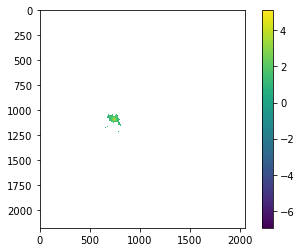

In [186]:
plt.imshow(data)
plt.colorbar()

Right now, however, we're dealing with pixel units. We don't really know how this translates to our sky coordinate system.

This is where a [World Coordinate System](https://docs.astropy.org/en/stable/wcs/index.html#:~:text=World%20Coordinate%20Systems%20(WCSs)%20describe,to%20wavelength%20in%20a%20spectrum) (WCS) comes into play. This structure, which is embedded in our FITS file, will help us construct an accurate conversion from pixel units to sky units.

In [184]:
f = fits.open(file)
w = WCS(f[1].header)
f.close()

[<Quantity 11.>, <Quantity 1.>]


Finally, we can plot these data with our WCS projection, along with some cosmetic enhancements.

The bright source in the center left is our star, Proxima Centauri. The spikes that jut out from that source are the HST point spread function. (describe).

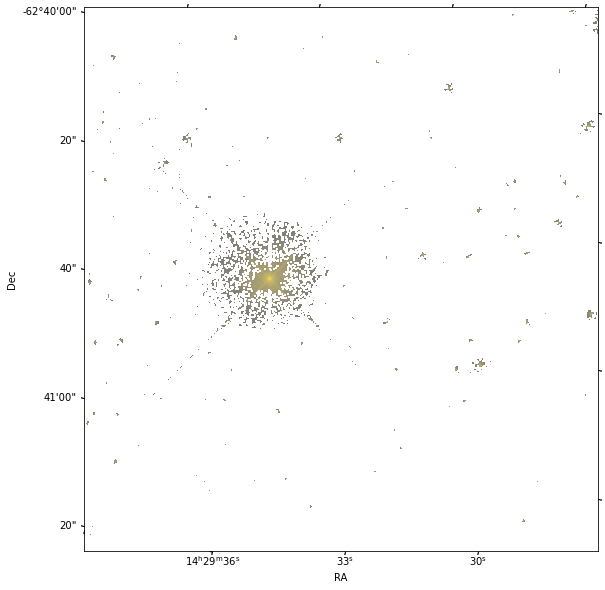

In [185]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(projection=w)
plt.imshow(data, origin='lower', cmap='cividis', aspect='equal')
plt.xlabel(r'RA')
plt.ylabel(r'Dec')

# Exercises
- Stack a number of observations of a single star. Are you able to align the coordinate systems?
- Repeat this process for Barnard's star.
- Extract the photometry from a single soruce over multiple exposures. Are there discernible brightness variations in the target?
- How many arcseconds have each of the highest proper motion targets moved over HST's lifetime?

# Resources
- [WCS primer](https://docs.astropy.org/en/stable/wcs/index.html#:~:text=World%20Coordinate%20Systems%20(WCSs)%20describe,to%20wavelength%20in%20a%20spectrum.)

# About this Notebook

**Last updated**: 2022-09-28

For support, contact archive@stsci.edu

# Citations
If you use `astropy`, `astroquery`, or `numpy` for published research, please cite the
authors. Follow these links for more information about citing `astropy`,
`astroquery`, and `numpy`:

* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `astroquery`](https://astroquery.readthedocs.io/en/latest/#astroquery)
* [Citing `numpy`](https://numpy.org/citing-numpy/)

[Top of Page](#top)<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>
